In [59]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [60]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.hdf5'

# Classification number setting

In [61]:
NUM_CLASSES = 6

# Input Length

In [62]:
TIME_STEPS = 16
DIMENSION = 2

# Load learning data

In [63]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [64]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [66]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [67]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 24)                792       
                                                                 
 dropout_7 (Dropout)         (None, 24)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                250       
                                                                 
 dense_11 (Dense)            (None, 6)                 66        
                                                                 
Total params: 1,108
Trainable params: 1,108
Non-trainable params: 0
_________________________________________________________________


In [68]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early abort
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [69]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [70]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
24/24 [==============================] - ETA: 0s - loss: 1.7621 - accuracy: 0.3487 
Epoch 1: saving model to model/point_history_classifier\point_history_classifier.hdf5
24/24 [==============================] - 1s 13ms/step - loss: 1.7621 - accuracy: 0.3487 - val_loss: 1.7264 - val_accuracy: 0.3098
Epoch 2/1000
24/24 [==============================] - ETA: 0s - loss: 1.6986 - accuracy: 0.3618
Epoch 2: saving model to model/point_history_classifier\point_history_classifier.hdf5
24/24 [==============================] - 0s 6ms/step - loss: 1.6986 - accuracy: 0.3618 - val_loss: 1.6601 - val_accuracy: 0.2990
Epoch 3/1000
23/24 [===========================>..] - ETA: 0s - loss: 1.6276 - accuracy: 0.3179
Epoch 3: saving model to model/point_history_classifier\point_history_classifier.hdf5
24/24 [==============================] - 0s 6ms/step - loss: 1.6272 - accuracy: 0.3167 - val_loss: 1.5763 - val_accuracy: 0.2931
Epoch 4/1000
 1/24 [>.............................] - ETA: 0s - l

In [71]:
# Loading saved models
model = tf.keras.models.load_model(model_save_path)

In [72]:
# reasoning test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 82ms/step
[9.9004364e-01 2.0538894e-03 7.7668400e-03 8.7950546e-05 3.1666666e-05
 1.6069740e-05]
0


# Confusion Matrix

32/32 [==============================] - 0s 1ms/step


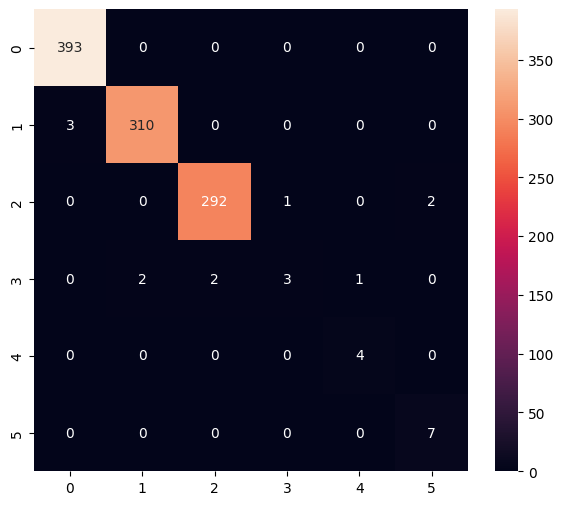

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       393
           1       0.99      0.99      0.99       313
           2       0.99      0.99      0.99       295
           3       0.75      0.38      0.50         8
           4       0.80      1.00      0.89         4
           5       0.78      1.00      0.88         7

    accuracy                           0.99      1020
   macro avg       0.88      0.89      0.87      1020
weighted avg       0.99      0.99      0.99      1020



In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite

In [74]:
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [75]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

In [76]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Hardik\AppData\Local\Temp\tmpkmup4io_\assets


INFO:tensorflow:Assets written to: C:\Users\Hardik\AppData\Local\Temp\tmpkmup4io_\assets


6572

# Reasoning test

In [77]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [78]:
# get input/output tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_4:0', 'index': 0, 'shape': array([ 1, 32]), 'shape_signature': array([-1, 32]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [79]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [80]:
%%time
# Inference execution
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [81]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.9004364e-01 2.0538892e-03 7.7668400e-03 8.7950633e-05 3.1666634e-05
 1.6069738e-05]
0
